In [1]:
from pydasa.workflows.phenomena import AnalysisEngine
from pydasa.elements.parameter import Variable
import numpy as np

In [2]:
variables_dict = {
    # Fluid density: ρ [M/L³]
    "\\rho": {
        "_idx": 0,
        "_sym": "\\rho",
        "_alias": "rho",
        "_fwk": "PHYSICAL",
        "_cat": "IN",
        "_name": "Density",
        "description": "Fluid density (water at 20°C)",
        "relevant": True,
        "_dims": "M*L^-3",
        "_units": "kg/m³",
        "_setpoint": 1000.0,
        "_std_setpoint": 1000.0,
        "_std_min": 990.0,
        "_std_max": 1020.0,
    },

    # Velocity: v [L/T]
    "v": {
        "_idx": 1,
        "_sym": "v",
        "_fwk": "PHYSICAL",
        "_cat": "IN",
        "_name": "Velocity",
        "description": "Flow velocity",
        "relevant": True,
        "_dims": "L*T^-1",
        "_units": "m/s",
        "_setpoint": 5.0,
        "_std_setpoint": 5.0,
        "_std_min": 4.5,
        "_std_max": 5.5,
    },

    # Pipe diameter: D [L]
    "D": {
        "_idx": 2,
        "_sym": "D",
        "_fwk": "PHYSICAL",
        "_cat": "IN",
        "_name": "Pipe Diameter",
        "relevant": True,
        "_dims": "L",
        "_units": "m",
        "_setpoint": 0.05,
        "_std_setpoint": 0.05,
        "_std_min": 0.045,
        "_std_max": 0.055,
    },

    # Dynamic viscosity: μ [M/(L·T)]
    "\\mu": {
        "_idx": 3,
        "_sym": "\\mu",
        "_fwk": "PHYSICAL",
        "_cat": "OUT",  # Exactly ONE output variable required
        "_name": "Dynamic Viscosity",
        "relevant": True,
        "_dims": "M*L^-1*T^-1",
        "_units": "Pa·s",
        "_setpoint": 0.001002,
        "_std_setpoint": 0.001002,
        "_std_min": 0.0009,
        "_std_max": 0.0011,
    },

    # Pressure drop: ΔP [M/(L·T²)]
    "P": {
        "_idx": 4,
        "_sym": "P",
        "_fwk": "PHYSICAL",
        "_cat": "CTRL",
        "_name": "Pressure Drop",
        "relevant": True,
        "_dims": "M*L^-1*T^-2",
        "_units": "Pa",
        "_setpoint": 5000.0,
        "_std_setpoint": 5000.0,
        "_std_min": 4500.0,
        "_std_max": 5500.0,
    },

    # Pipe length: L [L]
    "L": {
        "_idx": 5,
        "_sym": "L",
        "_fwk": "PHYSICAL",
        "_cat": "CTRL",
        "_name": "Pipe Length",
        "relevant": True,
        "_dims": "L",
        "_units": "m",
        "_setpoint": 10.0,
        "_std_setpoint": 10.0,
        "_std_min": 9.5,
        "_std_max": 10.5,
    },

    # Absolute roughness: ε [L]
    "\\varepsilon": {
        "_idx": 6,
        "_sym": "\\varepsilon",
        "_fwk": "PHYSICAL",
        "_cat": "CTRL",
        "_name": "Absolute Roughness",
        "relevant": True,
        "_dims": "L",
        "_units": "m",
        "_setpoint": 0.000025,
        "_std_setpoint": 0.000025,
        "_std_min": 0.00002,
        "_std_max": 0.00003,
    }
}

# Convert to Variable objects
variables = {
    sym: Variable(**params) for sym, params in variables_dict.items()
}

In [3]:
# Create engine
engine = AnalysisEngine(
    _idx=0,
    _fwk="PHYSICAL",
    _name="Pipe Flow Analysis",
    description="Dimensional analysis for Reynolds number and friction factor"
)

# Add variables
engine.variables = variables

In [4]:
# Execute dimensional analysis
results = engine.run_analysis()

print(f"Number of dimensionless groups: {len(engine.coefficients)}")

# Display results
for name, coeff in engine.coefficients.items():
    print(f"{name}: {coeff.pi_expr}")

Number of dimensionless groups: 4
\Pi_{0}: \frac{\mu}{\rho*v*D}
\Pi_{1}: \frac{P}{\rho*v^{2}}
\Pi_{2}: \frac{L}{D}
\Pi_{3}: \frac{\varepsilon}{D}


In [5]:
# Get Pi coefficient keys
pi_keys = list(engine.coefficients.keys())

# Derive Reynolds Number: Re = 1/Π₀ = ρvD/μ
Re_coeff = engine.derive_coefficient(
    expr=f"1/{pi_keys[0]}",
    symbol="Re",
    name="Reynolds Number",
    description="Re = ρvD/μ - Predicts flow regime",
    idx=-1
)

# Derive Darcy Friction Factor: f = 2(D/L)(ΔP/(ρv²)) = 2·(1/Π₁)·Π₂
f_coeff = engine.derive_coefficient(
    expr=f"2*{pi_keys[1]}^-1 * {pi_keys[2]}",
    symbol="Pd",
    name="Pressure Drop Ratio",
    description="Related to Darcy friction factor",
    idx=-1
)

# Relative Roughness: ε/D = Π₃
rough_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[3]}",
    symbol="\\epsilon/D",
    name="Relative Roughness",
    description="ε/D - Surface roughness effect",
    idx=-1
)

# Calculate numerical values
Re_val = Re_coeff.calculate_setpoint()
f_val = f_coeff.calculate_setpoint()
rough_val = rough_coeff.calculate_setpoint()

print(f"\nReynolds Number: {Re_val:.2e}")
print(f"Pressure Drop Ratio: {f_val:.6f}")
print(f"Relative Roughness: {rough_val:.2e}")


Reynolds Number: 2.50e+05
Pressure Drop Ratio: 40.000000
Relative Roughness: 5.00e-04


In [6]:
from pydasa.workflows.influence import SensitivityAnalysis

# Create sensitivity analyzer
sensitivity = SensitivityAnalysis(
    _idx=0,
    _fwk="PHYSICAL",
    _name="Reynolds Sensitivity",
    _cat="SYM"  # Symbolic analysis
)

# Configure with engine results
sensitivity.variables = engine.variables
sensitivity.coefficients = engine.coefficients

In [7]:
# Run symbolic analysis
symbolic_results = sensitivity.analyze_symbolic(val_type="mean")
symbolic_results

{'SEN_{\\Pi_{0}}': {'D': 1.0, '\\mu': -1.0, '\\rho': 1.0, 'v': 1.0},
 'SEN_{\\Pi_{1}}': {'P': -1.0, '\\rho': 1.0, 'v': 2.0},
 'SEN_{\\Pi_{2}}': {'D': 1.0, 'L': -1.0},
 'SEN_{\\Pi_{3}}': {'D': 1.0, '\\varepsilon': -1.0},
 'SEN_{Re}': {'D': -1.0, '\\mu': 1.0, '\\rho': -1.0, 'v': -1.0},
 'SEN_{Pd}': {'D': 2.0, 'L': -2.0, 'P': -2.0, '\\rho': 2.0, 'v': 4.0},
 'SEN_{\\epsilon/D}': {'D': 1.0, '\\varepsilon': -1.0}}

In [8]:
# Run symbolic analysis
symbolic_results = sensitivity.analyze_symbolic(val_type="mean")

# Display for Reynolds Number
Re_sensitivity = symbolic_results["SEN_{Re}"]

print("Reynolds Number Sensitivity:")
for var, sens_val in Re_sensitivity.items():
    if isinstance(sens_val, (int, float)):
        print(f"  ∂Re/∂{var}: {sens_val:+.4e}")

Reynolds Number Sensitivity:
  ∂Re/∂D: -1.0000e+00
  ∂Re/∂\mu: +1.0000e+00
  ∂Re/∂\rho: -1.0000e+00
  ∂Re/∂v: -1.0000e+00


In [9]:
import random
np.random.seed(42)
random.seed(42)

# Run numerical analysis
numerical_results = sensitivity.analyze_numeric(n_samples=1000)

# Display FAST sensitivity indices
Re_fast = numerical_results["SEN_{Re}"]

print("\nFAST Sensitivity for Reynolds Number:")
print(f"{'Variable':<15} {'First-Order (S1)':<20} {'Total-Order (ST)':<20}")
print("-" * 55)

var_names = Re_fast["names"]
S1_vals = Re_fast["S1"]
ST_vals = Re_fast["ST"]

for i, var_name in enumerate(var_names):
    print(f"{var_name:<15} {S1_vals[i]:<20.6f} {ST_vals[i]:<20.6f}")


FAST Sensitivity for Reynolds Number:
Variable        First-Order (S1)     Total-Order (ST)    
-------------------------------------------------------
D               0.007303             0.008226            
\mu             0.331045             0.333996            
\rho            0.327580             0.330425            
v               0.327492             0.330327            


In [10]:
from pydasa.workflows.practical import MonteCarloSimulation
import random

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

# Configure variable distributions
for var_sym, var in engine.variables.items():
    if var_sym == "v":
        # Vary velocity uniformly from 1.0 to 5.0 m/s
        a, b = 1.0, 5.0
        var._dist_type = "uniform"
        var._dist_params = {"a": a, "b": b}
        var._dist_func = lambda a=a, b=b: random.uniform(a, b)

    elif var_sym == "D":
        # Small variation in diameter
        a, b = 0.049, 0.051
        var._dist_type = "uniform"
        var._dist_params = {"a": a, "b": b}
        var._dist_func = lambda a=a, b=b: random.uniform(a, b)

    elif var_sym == "\\rho":
        # Density variation around water at 20°C
        a, b = 980.0, 1020.0
        var._dist_type = "uniform"
        var._dist_params = {"a": a, "b": b}
        var._dist_func = lambda a=a, b=b: random.uniform(a, b)

    else:
        # Keep other variables constant
        cst = var.setpoint
        var._dist_type = "constant"
        var._dist_params = {"value": cst}
        var._dist_func = lambda cst=cst: cst

In [11]:
# Create simulation handler
mc_handler = MonteCarloSimulation(
    _idx=0,
    _fwk="PHYSICAL",
    _name="Reynolds Monte Carlo",
    _cat="DIST",
    _experiments=500,
    _variables=engine.variables,
    _coefficients=engine.coefficients
)

# Run simulation
mc_handler.run_simulation(iters=500)

print(f"Simulation complete: {mc_handler.experiments} experiments")

Simulation complete: 500 experiments


In [12]:
# Get simulation keys
all_keys = list(mc_handler.simulations.keys())
derived_keys = [k for k in all_keys if not k.startswith('\\Pi_')]

# Extract results
pi_data = {}
for pi_key in derived_keys:
    pi_sim_obj = mc_handler.get_simulation(pi_key)
    pi_results = pi_sim_obj.extract_results()
    pi_data[pi_key] = pi_results[pi_key]

# Get Reynolds number simulation data
Re_sim = pi_data["Re"]

# Display statistics
print(f"\nReynolds Number Statistics:")
print(f"  Mean: {np.mean(Re_sim):.2e}")
print(f"  Std Dev: {np.std(Re_sim):.2e}")
print(f"  Min: {np.min(Re_sim):.2e}")
print(f"  Max: {np.max(Re_sim):.2e}")
print(f"  Range: {np.max(Re_sim) - np.min(Re_sim):.2e}")


Reynolds Number Statistics:
  Mean: 1.49e+05
  Std Dev: 5.79e+04
  Min: 4.97e+04
  Max: 2.51e+05
  Range: 2.01e+05


In [13]:
# Export coefficient data
coeff_export = {}
for name, coeff in engine.coefficients.items():
    coeff_export[name] = {
        "expression": str(coeff.pi_expr),
        "value": coeff.calculate_setpoint(),
        "variables": list(coeff.var_dims.keys()),
        "exponents": list(coeff.var_dims.values())
    }

# Export variable data
var_export = {}
for sym, var in engine.variables.items():
    var_export[sym] = {
        "name": var.name,
        "dims": var.dims,
        "units": var.units,
        "setpoint": var.setpoint
    }

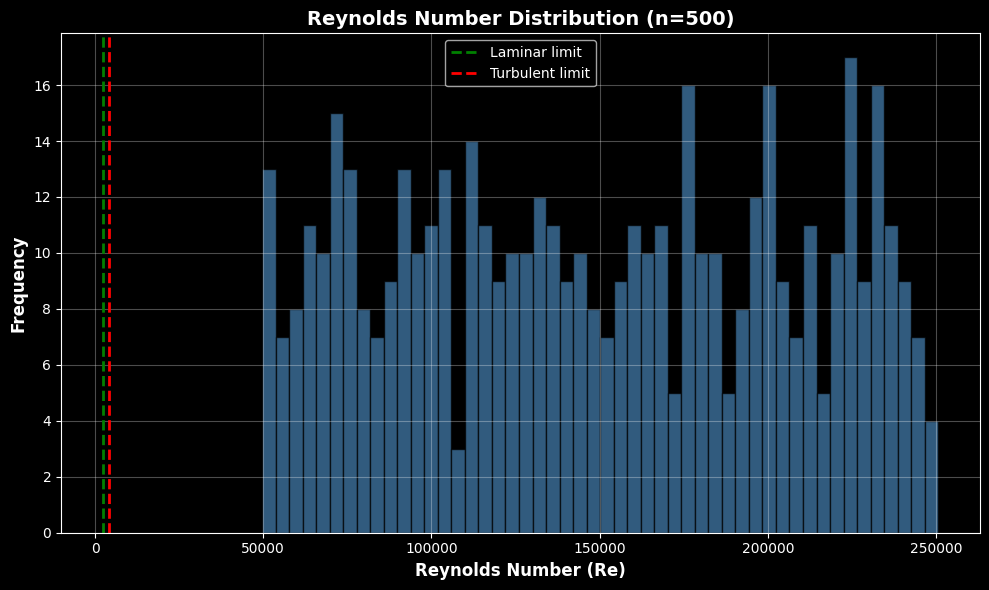

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))

# Plot histogram
ax.hist(Re_sim, bins=50, color="steelblue",
        alpha=0.7, edgecolor="black")

# Add flow regime boundaries
ax.axvline(2300, color="green", linestyle="--",
           linewidth=2, label="Laminar limit")
ax.axvline(4000, color="red", linestyle="--",
           linewidth=2, label="Turbulent limit")

# Labels and formatting
ax.set_xlabel("Reynolds Number (Re)", fontsize=12, fontweight="bold")
ax.set_ylabel("Frequency", fontsize=12, fontweight="bold")
ax.set_title(f"Reynolds Number Distribution (n={len(Re_sim)})",
             fontsize=14, fontweight="bold")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

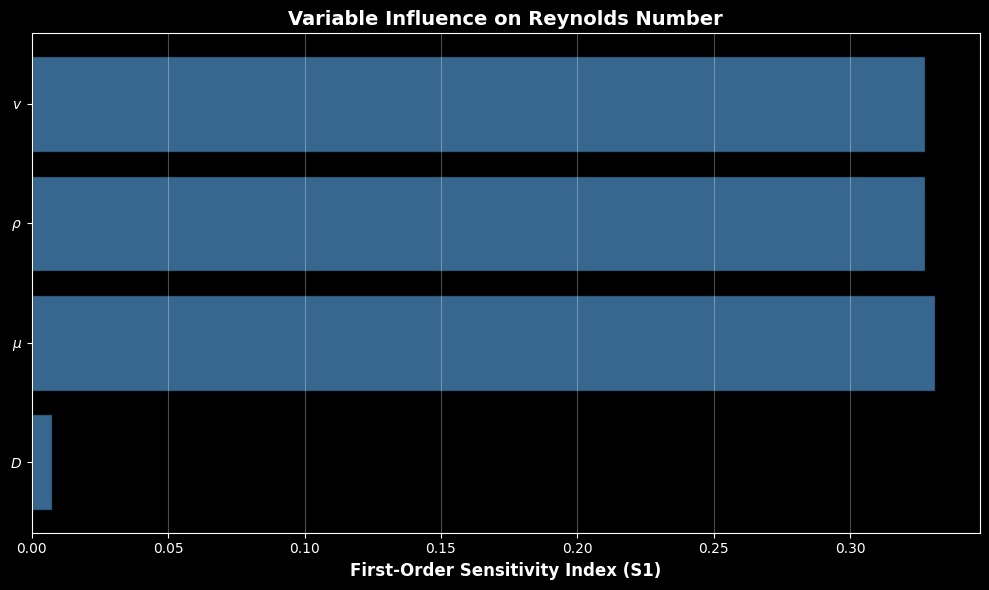

In [15]:
fig, ax = plt.subplots(figsize=(10, 6))

# Get FAST results
Re_fast = numerical_results["SEN_{Re}"]
var_names = Re_fast["names"]
S1_vals = Re_fast["S1"]

# Create bar chart
y_pos = np.arange(len(var_names))
ax.barh(y_pos, S1_vals, color="steelblue",
        alpha=0.8, edgecolor="black")

# Formatting
ax.set_yticks(y_pos)
ax.set_yticklabels([f"${name}$" for name in var_names])
ax.set_xlabel("First-Order Sensitivity Index (S1)",
              fontsize=12, fontweight="bold")
ax.set_title("Variable Influence on Reynolds Number",
             fontsize=14, fontweight="bold")
ax.grid(True, alpha=0.3, axis="x")

plt.tight_layout()
plt.show()

In [16]:
import pandas as pd
import os

# Create data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Create DataFrame from simulation results
sim_df = pd.DataFrame({
    "Re": Re_sim,
    "epsilon_D": pi_data["\\epsilon/D"],
    "Pd": pi_data["Pd"]
})

# Statistical summary
print(sim_df.describe())

# Export to CSV
sim_df.to_csv("data/reynolds_simulation.csv", index=False)
print("CSV exported to data/reynolds_simulation.csv")

                  Re   epsilon_D           Pd
count     500.000000  500.000000   500.000000
mean   148946.563507    0.000500   406.714082
std     57960.747600    0.000006   418.420920
min     49650.234498    0.000490    80.368175
25%     98126.517553    0.000496   124.742090
50%    146277.430667    0.000500   230.966358
75%    200100.571570    0.000505   513.397838
max    250649.469199    0.000510  2006.810464
CSV exported to data/reynolds_simulation.csv


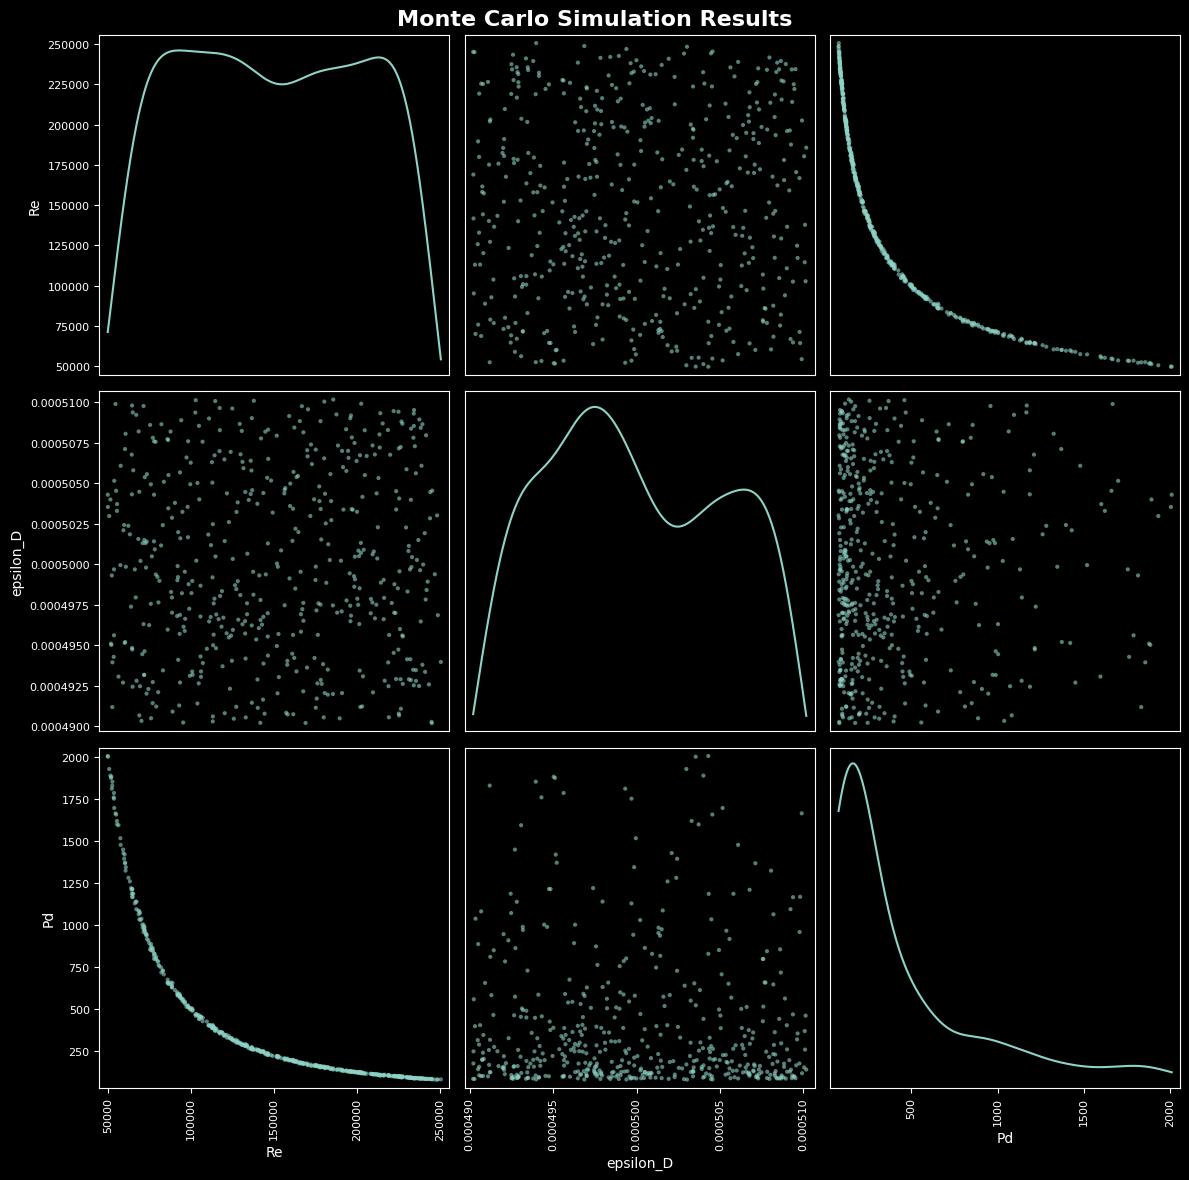

In [17]:
from pandas.plotting import scatter_matrix

# Create scatter matrix
scatter_matrix(sim_df, figsize=(12, 12),
               alpha=0.6, diagonal="kde")
plt.suptitle("Monte Carlo Simulation Results",
             fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

In [18]:
import json
import os

# Create data directory if it doesn't exist
os.makedirs("data", exist_ok=True)

# Export to JSON for web applications
export_data = {
    "coefficients": coeff_export,
    "variables": var_export,
    "simulation": {
        "n_samples": len(Re_sim),
        "Re_mean": float(np.mean(Re_sim)),
        "Re_std": float(np.std(Re_sim)),
        "Re_data": Re_sim.tolist()
    }
}

with open("data/pydasa_results.json", "w") as f:
    json.dump(export_data, f, indent=4)

print("Results exported to data/pydasa_results.json")

Results exported to data/pydasa_results.json
